In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf 

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import metrics

from sklearn.metrics import mean_squared_error


In [92]:
# data
ticker = 'ANF'
start_date = '2010-01-02'
end_date = '2019-12-31'
n_lags = 3

valid_size = 12
batch_size = 5
n_epochs = 1000

In [93]:
df = yf.download(ticker,
    start = start_date,
    end = end_date,
    progress = False)

df = df.resample('M').last()
prices = df['Adj Close'].values

Text(0, 0.5, 'Price ($)')

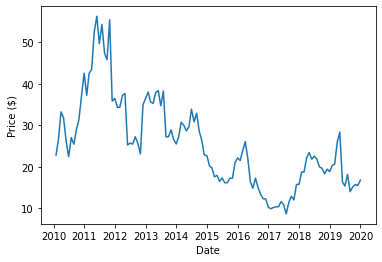

In [94]:
fig, ax = plt.subplots( )

ax.plot(df.index, prices)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

In [95]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    '''
    Function for transforming time series into input acceptable by multilayer perceptron.abs

    Parameters
    ----------
    series : np.array
        Array of features 
    n_steps_in : int
        The number of lagged observations to consider as features

    Returns 
    -------
    X : np.array 
        Array of features 
    Y : np.array 
        Array of features
    '''

    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        X.append(sequence[i:end_ix])
        y.append(sequence[end_ix:out_end_ix])
    return np.array(X), np.array(y)

In [96]:
# def get_batch(vectorized_songs, seq_length, batch_size):
#   # the length of the vectorized songs string
#   n = vectorized_songs.shape[0] - 1
#   # randomly choose the starting indices for the examples in the training batch
# #   idx = np.linspace(0,batch_size,batch_size+1)

# #   '''TODO: construct a list of input sequences for the training batch'''
#   input_batch = [vectorized_songs[i : i+seq_length] for i in range(batch_size)]
# #   input_batch = # TODO  
# #   '''TODO: construct a list of output sequences for the training batch'''
#   output_batch = [vectorized_songs[i+seq_length] for i in range(batch_size)]
# #   output_batch = # TODO

#   # x_batch, y_batch provide the true inputs and targets for network training
#   x_batch = np.reshape(input_batch, [batch_size, seq_length])
#   y_batch = np.reshape(output_batch, [batch_size, 1])
#   return x_batch, y_batch

In [97]:
X, y = split_sequence(prices, 3,1)
# X, y = create_input_data(prices, n_lags)


In [98]:
valid_ind = len(X) - valid_size

X_train = X[:-valid_ind]
y_train = y[:-valid_ind].reshape(-1,1)

X_val = X[-valid_ind:]
y_val = y[-valid_ind:].reshape(-1,1)

In [99]:
print(X_train[1])
print(y_train[0])

[26.52302933 33.23754501 31.84658432]
[31.84658432]


In [100]:
y_valid = prices[len(prices) - valid_size:]
y_valid

array([20.404356  , 20.66800117, 26.01153374, 28.36499977, 16.41734695,
       15.40955639, 18.18596268, 14.04536724, 15.19342136, 15.76804543,
       15.55377865, 16.82314491])

In [101]:
X_train.shape

(12, 3)

In [102]:
print(f'Size of datasets - training: {X_train.shape[0]} | validation: {X_valid.shape[0]}')

Size of datasets - training: 12 | validation: 12


In [103]:
# One step behind!
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]
# print(len(naive_pred))
# print(len(y_valid))
naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 17.37, RMSE: 4.17


In [114]:
class MLP(tf.keras.Model):

    # In __init__, we define the Model's layers
    def __init__(self,steps_out, batch_size):
        super(MLP, self).__init__()
        self.dense_layer1 = tf.keras.layers.Dense(8, activation='relu', input_shape=(3,))
        self.drop_out_layer_1 = tf.keras.layers.Dropout(0.2)
        self.dense_layer2 = tf.keras.layers.Dense(4, activation = 'relu' )
        self.drop_out_layer_2 = tf.keras.layers.Dropout(0.2)
        self.dense_layer3 = tf.keras.layers.Dense(steps_out, activation = 'relu' )

    # In the call function, we define the Model's forward pass.
    def build(self):
        model = tf.keras.Sequential([
        # Layer 1: 
        self.dense_layer1,
        self.drop_out_layer_1,
        # Layer 2:
        self.dense_layer2,
        self.drop_out_layer_2,
        # Layer 3:
        self.dense_layer3 
        ])

        return model

In [116]:
tf.random.set_seed(42)
model = MLP(1,3).build()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 8)                 32        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [107]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 3 # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 0.0001  # Experiment between 1e-5 and 1e-1

# Model parameters: 
steps_in = 3
steps_out = 1
embedding_dim = 8 
# rnn_units = 1024  # Experiment between 1 and 2048

In [111]:
model = MLP(steps_out, embedding_dim, batch_size).build()
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer,
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [52]:
X_train.shape

(118, 3)

In [ ]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(n_epochs):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        
        model.eval()
        
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

In [99]:
tf.random.set_seed(42)
model = MLP(3,1)

In [48]:
valid_ind = len(X) - valid_size
t
dataset = TensorDataset(X_tensor, y_tensor)

# train_dataset = Subset(dataset, list(range(valid_ind)))
# valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=BATCH_SIZE)
# valid_loader = DataLoader(dataset=valid_dataset, 
#                           batch_size=BATCH_SIZE)

NameError: name 'TensorDataset' is not defined

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units), 
    # LSTM('''TODO'''),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
    # '''TODO: DENSE LAYER HERE'''
  ])